In [303]:
%load_ext autoreload
%autoreload 2
# Investigating why TTA average performs poorly
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from augmentations import get_aug_idxs
from scipy.special import softmax

#sys.path.insert(0, '/local/divyas/icml_testaug')
sns.set_style('white')

model_name = 'MobileNetV2'
aug_name = 'five_crop'
agg_output_path = './outputs/aggregated_outputs/' + model_name + '/' + aug_name + '/mean.h5'
orig_output_path = './outputs/aggregated_outputs/' + model_name + '/orig/mean.h5'

agg_hf = h5py.File(agg_output_path, 'r')
orig_hf = h5py.File(orig_output_path, 'r')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
# TODO: show how many labels TTA helps, how many labels TTA doesn't
# calculate class specific accuracy w/o TTA
# calculate class specific accuracy w/ TTA
tta_output = []
raw_output = []
labels = []
n_changed_right = 0
n_changed_wrong = 0
n_changed_neutral = 0
batch_accs = []
orig_batch_accs = []

wrong_aug_output = []
wrong_raw_output = []
wrong_labels = []

right_aug_output = []
right_raw_output = []
right_labels = []

with h5py.File(agg_output_path, 'r') as agg_hf:
    with h5py.File(orig_output_path, 'r') as orig_hf:
        for key in agg_hf.keys():
            if 'labels' in key:
                continue
            aug_output = agg_hf[key].value
            orig_output = orig_hf[key].value
            target = agg_hf[key[:-7] + 'labels'].value
            
            aug_labels = np.argmax(aug_output, axis=1)
            orig_labels = np.argmax(orig_output, axis=1)
            #print(aug_labels.shape)
            #print(orig_labels.shape)
            
            orig_true = orig_labels == target
            aug_true = aug_labels == target
            
            tta_changed = np.where(aug_labels != orig_labels)[0]
            tta_changed_wrong = set(np.where(orig_true == True)[0]).intersection(np.where(aug_true == False)[0])
            tta_changed_right = set(np.where(orig_true == False)[0]).intersection(np.where(aug_true == True)[0])
            tta_changed_neutral = set(tta_changed).difference(tta_changed_wrong).difference(tta_changed_right)
            
            tta_changed_right_idxs = np.array(list(tta_changed_right)).astype(int)
            tta_changed_wrong_idxs = np.array(list(tta_changed_wrong)).astype(int)

            n_changed_right += len(tta_changed_right)
            n_changed_wrong += len(tta_changed_wrong)
            n_changed_neutral += len(tta_changed_neutral)
            if len(tta_changed_wrong) > 0:
                wrong_aug_output.append(aug_output[tta_changed_wrong_idxs])
                wrong_raw_output.append(orig_output[tta_changed_wrong_idxs])
                wrong_labels.append(target[tta_changed_wrong_idxs])

                right_aug_output.append(aug_output[tta_changed_right_idxs])
                right_raw_output.append(orig_output[tta_changed_right_idxs])
                right_labels.append(target[tta_changed_right_idxs])
wrong_aug_outputs = np.concatenate(wrong_aug_output, axis=0)
wrong_raw_outputs = np.concatenate(wrong_raw_output, axis=0)
wrong_aug_softmax = softmax(wrong_aug_outputs, axis=1)
wrong_raw_softmax = softmax(wrong_raw_outputs, axis=1)
wrong_labels = np.concatenate(wrong_labels).astype(int)
wrong_aug_preds = np.argmax(wrong_aug_outputs, axis=1)
wrong_raw_preds = np.argmax(wrong_raw_outputs, axis=1)

right_aug_outputs = np.concatenate(right_aug_output, axis=0)
right_raw_outputs = np.concatenate(right_raw_output, axis=0)
right_aug_softmax = softmax(right_aug_outputs, axis=1)
right_raw_softmax = softmax(right_raw_outputs, axis=1)
right_labels = np.concatenate(right_labels).astype(int)
right_aug_preds = np.argmax(right_aug_outputs, axis=1)
right_raw_preds = np.argmax(right_raw_outputs, axis=1)

print(n_changed_right, n_changed_wrong, n_changed_neutral)

/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:26: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:27: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


1240 855 1998


0.40352947


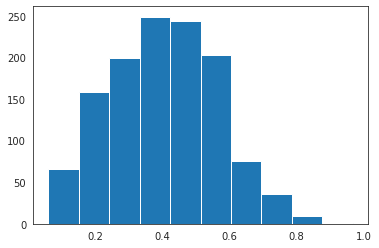

In [305]:
# Graph of how TTA improves predictions
n_right = len(right_labels)
aug_correct_label_probs = right_aug_softmax[np.arange(n_right),right_labels]
orig_correct_label_probs = right_raw_softmax[np.arange(n_right), right_labels]
aug_pred_label_probs = right_aug_softmax[np.arange(n_right),right_aug_preds]
orig_pred_label_probs = right_raw_softmax[np.arange(n_right), right_raw_preds]

correct_diffs = aug_correct_label_probs - orig_correct_label_probs
pred_diffs = aug_pred_label_probs - orig_pred_label_probs
#plt.plot(correct_diffs[np.argsort(correct_diffs)])
#plt.plot(pred_diffs[np.argsort(pred_diffs)])
#np.mean(aug_pred_label_probs)
plt.hist(aug_pred_label_probs)
right_aug_pred_label_probs = aug_pred_label_probs
right_pred_diffs = pred_diffs
right_aug_prod_probs = np.var(right_aug_softmax, axis=1)

print(np.mean(aug_pred_label_probs))

0.3890235


(array([ 20.,  87., 141., 184., 208., 161.,  39.,  11.,   4.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

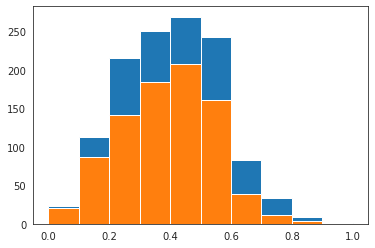

In [306]:
# Graph of how TTA reduces prediction accuracy
n_wrong = len(wrong_labels)
aug_correct_label_probs = wrong_aug_softmax[np.arange(n_wrong),wrong_labels]
orig_correct_label_probs = wrong_raw_softmax[np.arange(n_wrong), wrong_labels]
aug_pred_label_probs = wrong_aug_softmax[np.arange(n_wrong),wrong_aug_preds]
orig_pred_label_probs = wrong_raw_softmax[np.arange(n_wrong), wrong_raw_preds]

correct_diffs = aug_correct_label_probs - orig_correct_label_probs
pred_diffs = aug_pred_label_probs - orig_pred_label_probs
#plt.plot(correct_diffs[np.argsort(correct_diffs)])
#plt.plot(pred_diffs[np.argsort(pred_diffs)])

# all this shows is that the predicted probability for the correct class 
# decreases with test-time augmentation - by a lot 
wrong_aug_pred_label_probs = aug_pred_label_probs
wrong_pred_diffs = pred_diffs
wrong_aug_prod_probs = np.var(wrong_aug_softmax, axis=1)
print(np.mean(aug_pred_label_probs))
plt.hist(right_aug_pred_label_probs, bins=10, range=(0,1))
plt.hist(wrong_aug_pred_label_probs, bins=10, range=(0,1))


(array([  0.,   8.,  35.,  93., 322., 289.,  87.,  15.,   5.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <a list of 10 Patch objects>)

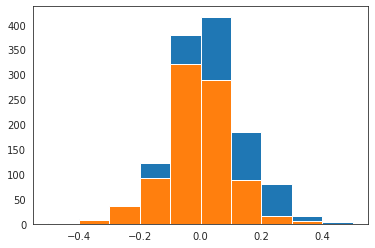

In [307]:
plt.hist(right_pred_diffs, bins=10, range=(-.5,.5))
plt.hist(wrong_pred_diffs, bins=10, range=(-.5,.5))

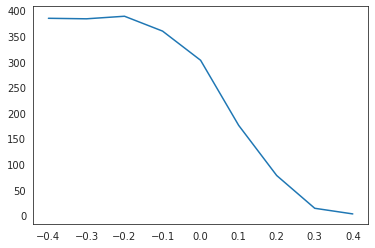

In [308]:
nets = []
thresh_opts = [-.4, -.3, -.2, -.1, 0, .1, .2, .3, .4]
for i in thresh_opts:
    net = len(np.where(right_pred_diffs > i)[0]) - len(np.where(wrong_pred_diffs > i)[0])
    nets.append(net)
plt.plot(thresh_opts, nets)

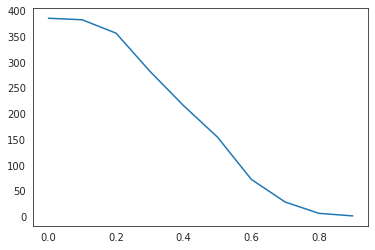

In [309]:
nets = []
thresh_opts = np.arange(0, 1, .1)
for i in thresh_opts:
    n_right = len(np.where(right_aug_pred_label_probs > i)[0]) 
    n_wrong = len(np.where(wrong_aug_pred_label_probs > i)[0])
    net = n_right - n_wrong
    nets.append(net)
plt.plot(thresh_opts, nets)

(array([127., 165., 188., 153., 165.,  51.,   3.,   3.,   0.,   0.]),
 array([0.e+00, 1.e-04, 2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04,
        8.e-04, 9.e-04, 1.e-03], dtype=float32),
 <a list of 10 Patch objects>)

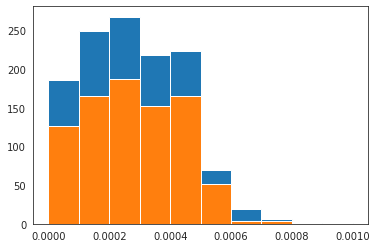

In [310]:
plt.hist(right_aug_prod_probs, bins=10, range=(0, .001))
plt.hist(wrong_aug_prod_probs, bins=10, range=(0, .001))


(array([  8.,  22.,  73., 131., 180., 189., 116.,  88.,  39.,   9.]),
 array([5.12084953e-05, 6.14776582e-05, 7.17468283e-05, 8.20159912e-05,
        9.22851614e-05, 1.02554324e-04, 1.12823487e-04, 1.23092657e-04,
        1.33361827e-04, 1.43630983e-04, 1.53900153e-04], dtype=float32),
 <a list of 10 Patch objects>)

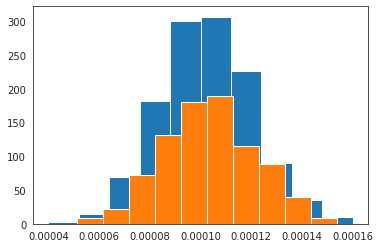

In [311]:
plt.hist(np.mean(right_aug_outputs, axis=1), bins=10)
plt.hist(np.mean(wrong_aug_outputs, axis=1), bins=10)

(array([  0.,   3.,  17.,  45., 119., 287., 342.,  41.]),
 array([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1],
       dtype=float32),
 <a list of 8 Patch objects>)

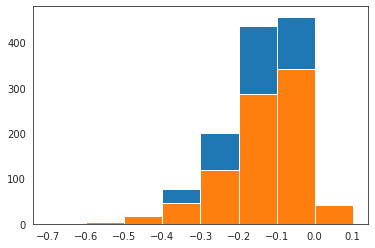

In [312]:
n_wrong = len(wrong_raw_preds)
n_right = len(right_raw_preds)
wrong_aug_pred_label_probs = wrong_aug_softmax[np.arange(n_wrong),wrong_raw_preds]
wrong_orig_aug_pred_label_probs = wrong_raw_softmax[np.arange(n_wrong), wrong_raw_preds]


right_aug_pred_label_probs = right_aug_softmax[np.arange(n_right),right_raw_preds]
right_orig_aug_pred_label_probs = right_raw_softmax[np.arange(n_right), right_raw_preds]
right_diff = right_aug_pred_label_probs - right_orig_aug_pred_label_probs
wrong_diff = wrong_aug_pred_label_probs - wrong_orig_aug_pred_label_probs
plt.hist(right_diff, bins=8, range=(-.7, .1))
plt.hist(wrong_diff, bins=8, range=(-.7, .1))

# how does the predicted probability for the originally predicted class change with TTA?


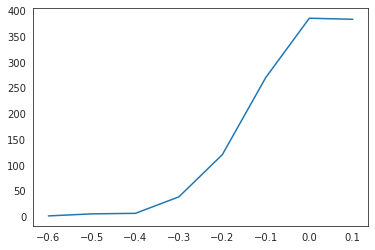

In [313]:
nets = []
thresh_opts = np.arange(-.6, .2, .1)
for i in thresh_opts:
    n_right = len(np.where(right_diff < i)[0]) 
    n_wrong = len(np.where(wrong_diff < i)[0])
    net = n_right - n_wrong
    nets.append(net)
plt.plot(thresh_opts, nets)

In [ ]:
# Class-specific accuracies
# Five-crop specifically; how many misclassified examples across all architectures?
# how many correctly classified examples?
# How are these inaccuracies distributed over class?